<a href="https://colab.research.google.com/github/saipranavmadineni/Traffic-Sign-Recognition/blob/main/Traffic_Sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [191]:
from zipfile import ZipFile

In [192]:
f="test.zip"
with ZipFile(f,'r') as z:
  z.extractall()
  print('Done')

Done


In [3]:
!pip install utils
from importlib import reload
import utils; reload(utils)
from utils import *

In [4]:
import pickle
import tensorflow.compat.v1 as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import time
import os
from PIL import Image
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout


In [5]:
if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

tpu_address = TF_MASTER

In [7]:
models_path = "./models/"
data = []
labels = []
classes = 23
cur_path = os.getcwd()
for i in range(classes):
    path = os.path.join(cur_path,'Dataset',str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(path + '//'+ a)
            image = image.resize((32,32))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")
data = np.array(data)
labels = np.array(labels)

In [8]:
print(data.shape, labels.shape)


(20879, 32, 32, 3) (20879,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=23)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23) 

In [10]:
print("Features shape: ", X_train.shape)
print("Leatures shape: ", y_train.shape)

Features shape:  (15032, 32, 32, 3)
Leatures shape:  (15032,)


In [11]:
n_train = X_train.shape[0]

n_validation = X_val.shape[0]

n_test = X_test.shape[0]

image_shape = X_train.shape[1:]

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 15032
Number of validation examples = 3759
Number of testing examples = 2088
Image data shape = (32, 32, 3)
Number of classes = 23


In [12]:
sign_names = pd.read_csv("Sign_Description.csv")
sign_names.set_index("ClassId")

sign_names.head(n=3)

ClassId              SignName
0        0  Speed Limit 20 Km/hr
1        1  Speed Limit 30 Km/hr
2        2  Speed Limit 50 Km/hr

In [13]:
def group_img_id_to_lbl(lbs_ids, lbs_names):    
    arr_map = []
    for i in range(0, lbs_ids.shape[0]):
        label_id = lbs_ids[i]
        label_name = lbs_names[lbs_names["ClassId"] == label_id]["SignName"].values[0]
        arr_map.append({"img_id": i, "label_id": label_id, "label_name": label_name})
    return pd.DataFrame(arr_map)


In [14]:
def group_img_id_to_lb_count(img_id_to_lb):

    return pd.pivot_table(img_id_to_lb, index=["label_id", "label_name"], values=["img_id"], aggfunc='count')

In [15]:
def show_random_dataset_images(group_label, imgs, to_show=5):

    for (lid, lbl), group in group_label:
        rand_idx = np.random.randint(0, high=group['img_id'].size, size=to_show, dtype='int')
        selected_rows = group.iloc[rand_idx]

        selected_img = list(map(lambda img_id: imgs[img_id], selected_rows['img_id']))
        selected_labels = list(map(lambda label_id: label_id, selected_rows['label_id']))
        show_image_list(selected_img, selected_labels, "{0}: {1}".format(lid, lbl), cols=to_show, fig_size=(7, 7), show_ticks=False)

In [16]:
def show_image_list(img_list, img_labels, title, cols=2, fig_size=(15, 15), show_ticks=True):

    img_count = len(img_list)
    rows = img_count // cols
    cmap = None

    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    for i in range(0, img_count):
        img_name = img_labels[i]     
        img = img_list[i]
        if len(img.shape) < 3 or img.shape[-1] < 3:
            cmap = "gray"
            img = np.reshape(img, (img.shape[0], img.shape[1]))

        if not show_ticks:            
            axes[i].axis("off")

        axes[i].imshow(img, cmap=cmap)

    fig.suptitle(title, fontsize=12, fontweight='bold', y = 0.6)
    fig.tight_layout()
    plt.show()

    return

In [17]:

X_train_id_to_label = group_img_id_to_lbl(y_train, sign_names)
X_train_id_to_label.tail(n=3)

img_id  label_id            label_name
15029   15029        19         Slippery Road
15030   15030        16           Men at Work
15031   15031         3  Speed Limit 60 Km/hr

In [18]:
X_train_group_by_label_count = group_img_id_to_lb_count(X_train_id_to_label)
X_train_group_by_label_count.head(n=5)

img_id
label_id label_name                  
0        Speed Limit 20 Km/hr     147
1        Speed Limit 30 Km/hr    1593
2        Speed Limit 50 Km/hr    1645
3        Speed Limit 60 Km/hr    1008
4        Speed Limit 70 Km/hr    1450

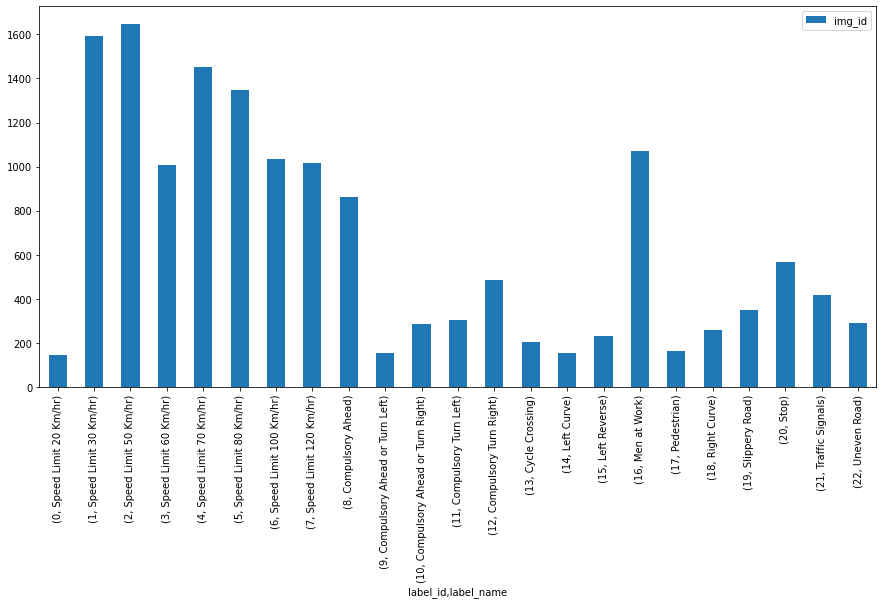

In [19]:
X_train_group_by_label_count.plot(kind='bar', figsize=(15, 7))


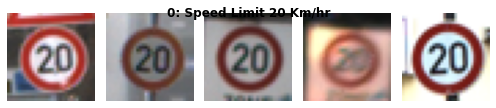

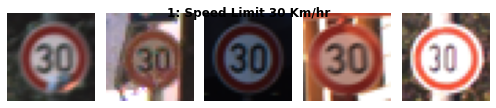

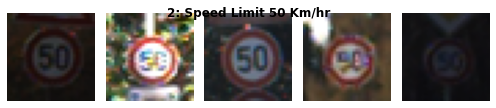

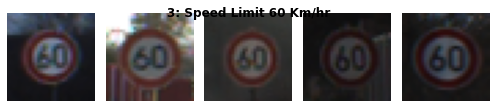

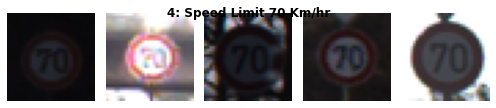

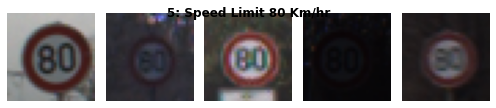

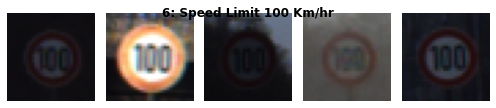

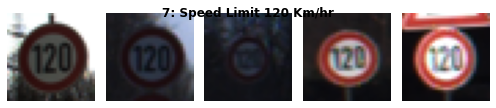

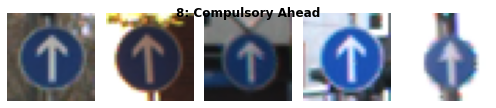

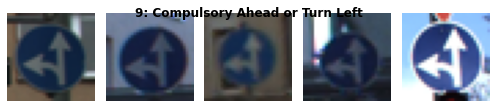

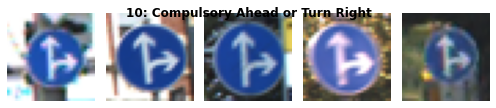

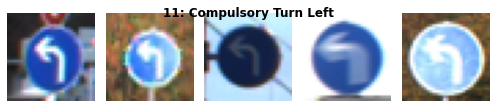

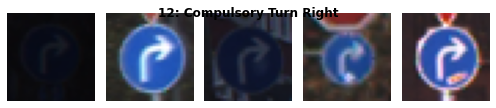

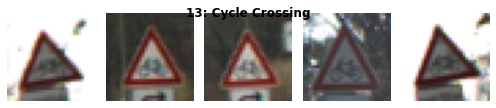

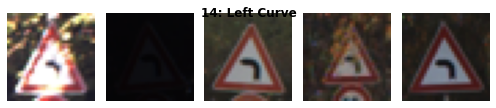

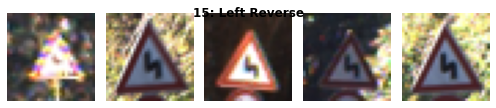

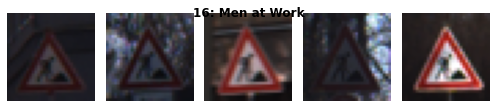

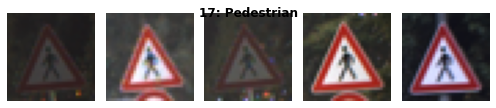

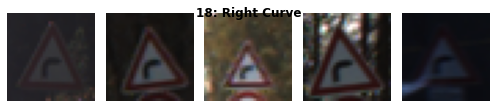

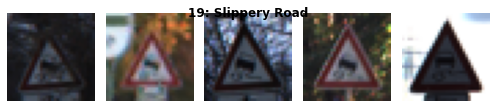

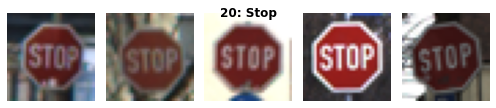

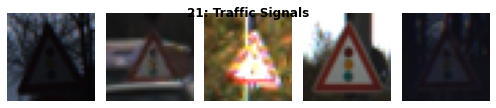

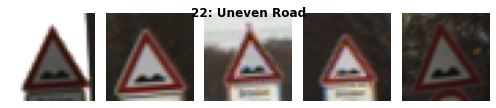

In [20]:
X_train_group_by_label = X_train_id_to_label.groupby(["label_id", "label_name"])
img_per_class = 5

show_random_dataset_images(X_train_group_by_label, X_train)

Validation

In [21]:
X_valid_id_to_label = group_img_id_to_lbl(y_val, sign_names)

X_valid_id_to_label.head(n=3)

img_id  label_id             label_name
0       0         6  Speed Limit 100 Km/hr
1       1        16            Men at Work
2       2         8       Compulsory Ahead

In [22]:
X_valid_group_by_label_count = group_img_id_to_lb_count(X_valid_id_to_label)
X_valid_group_by_label_count.head(n=3)

img_id
label_id label_name                  
0        Speed Limit 20 Km/hr      34
1        Speed Limit 30 Km/hr     387
2        Speed Limit 50 Km/hr     389

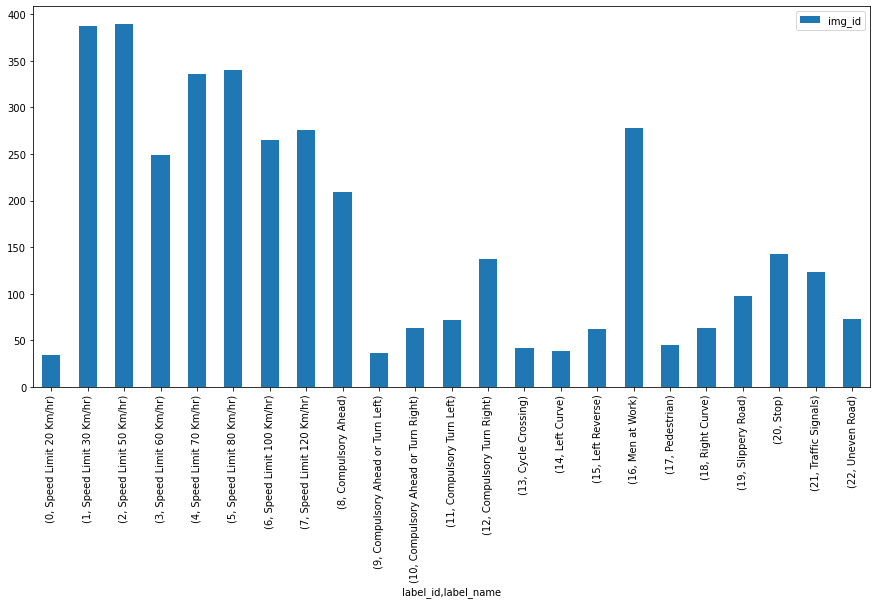

In [23]:
X_valid_group_by_label_count.plot(kind='bar', figsize=(15, 7))


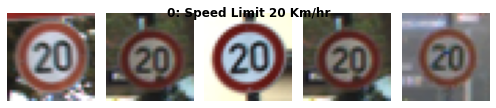

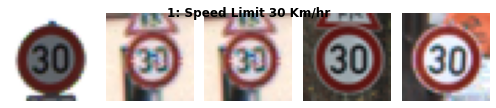

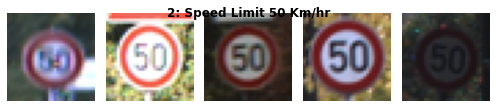

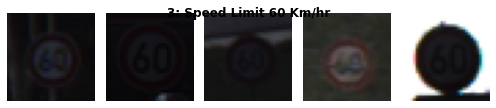

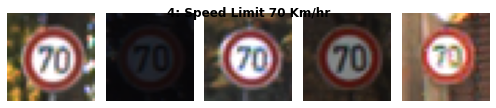

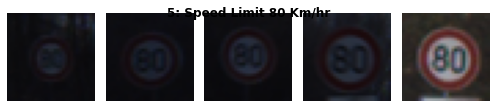

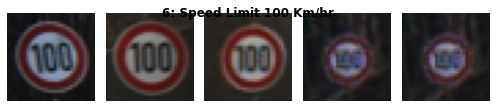

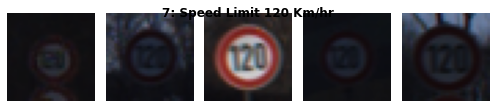

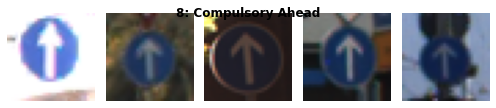

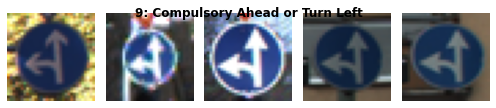

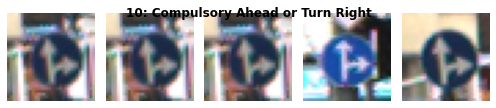

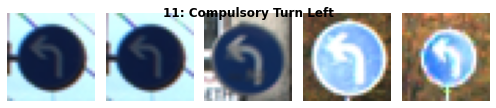

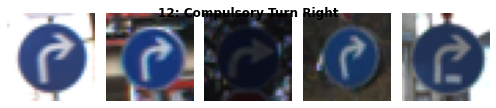

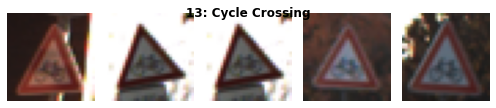

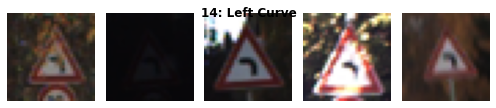

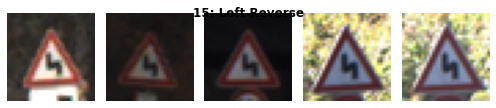

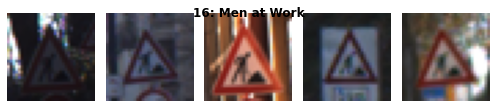

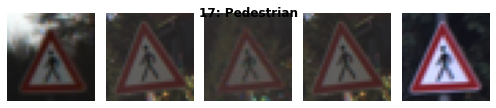

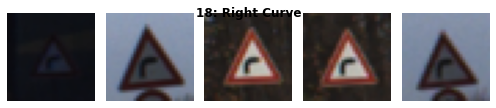

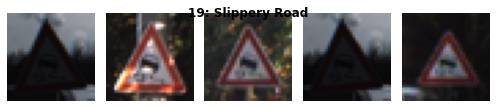

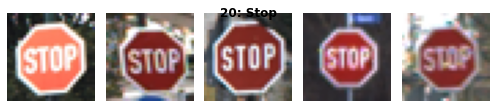

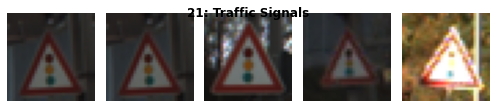

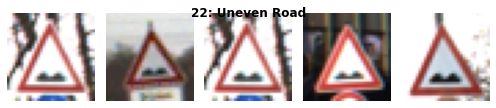

In [24]:
X_valid_group_by_label = X_valid_id_to_label.groupby(["label_id", "label_name"])

show_random_dataset_images(X_valid_group_by_label, X_val)

In [25]:
def normalise_images(imgs, dist):
    
    std = np.std(dist)
    mean = np.mean(dist)
    return (imgs - mean) / std

In [26]:
X_train_normalised = normalise_images(X_train, X_train)


In [27]:
X_valid_normalised = normalise_images(X_val, X_train) 
X_test_normalised = normalise_images(X_test, X_train)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


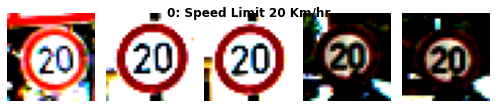

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


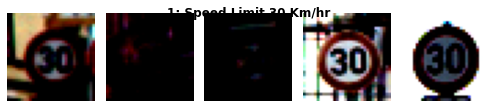

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


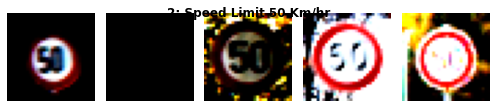

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


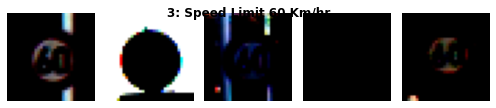

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


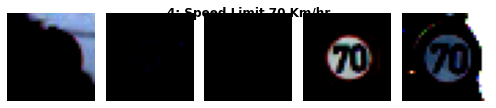

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


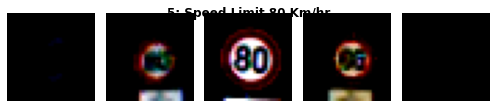

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


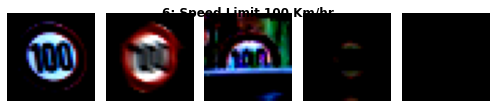

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


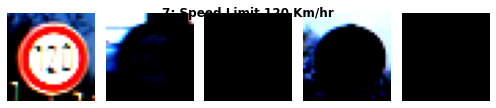

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


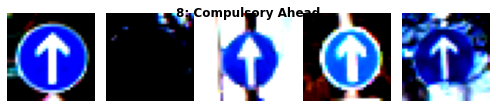

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


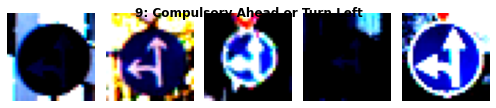

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


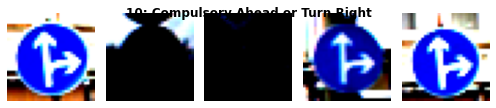

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


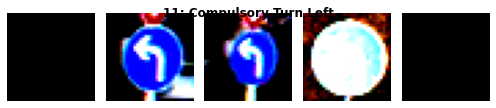

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


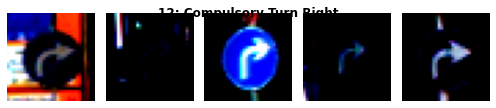

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


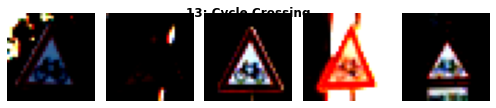

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


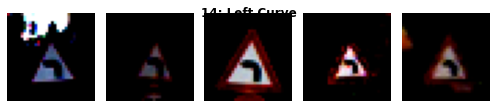

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


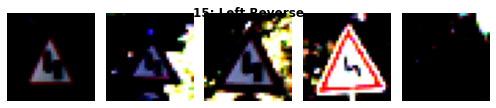

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


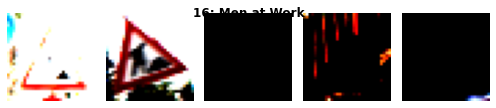

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


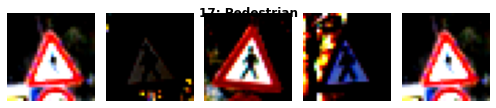

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


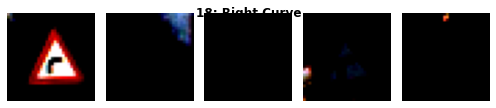

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


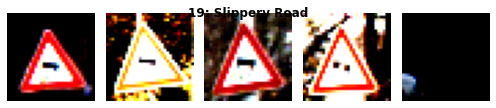

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


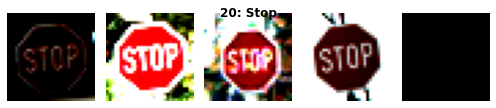

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


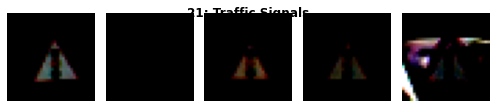

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


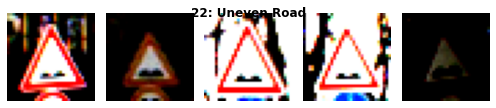

In [28]:
show_random_dataset_images(X_valid_group_by_label, X_valid_normalised)


Grayscale


In [29]:
def to_grayscale(img):

    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

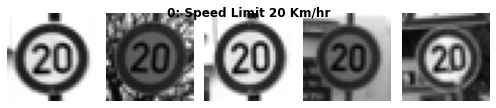

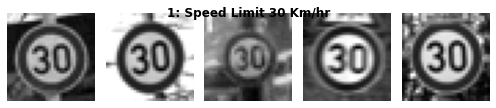

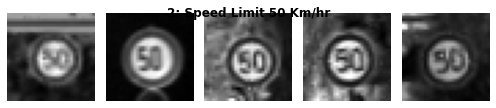

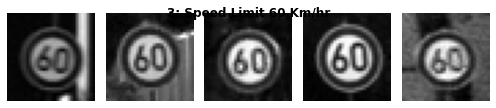

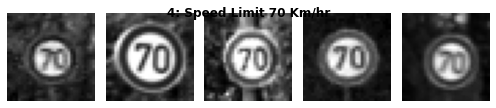

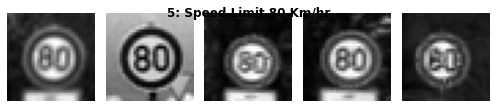

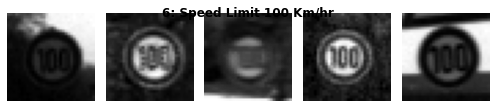

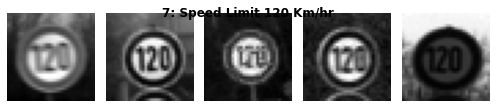

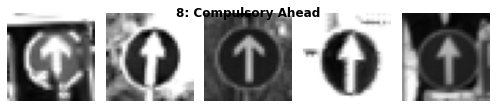

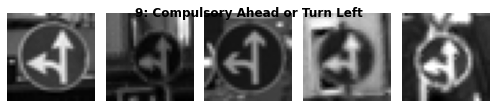

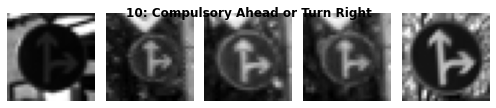

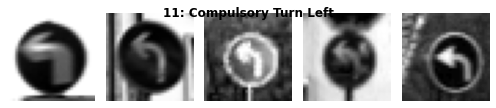

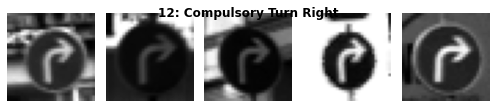

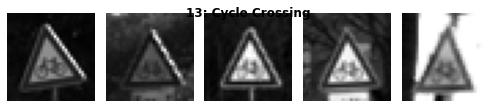

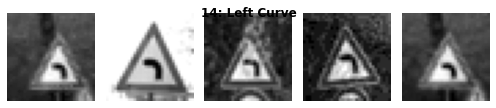

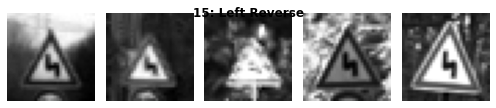

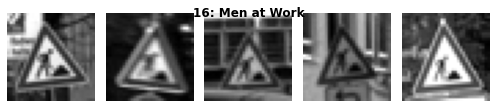

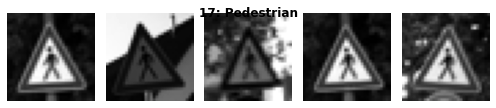

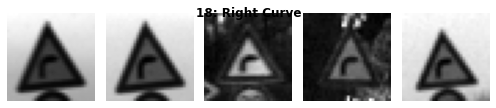

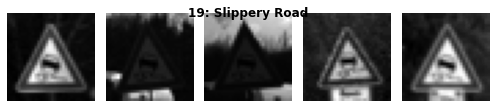

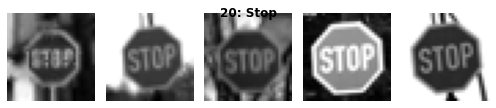

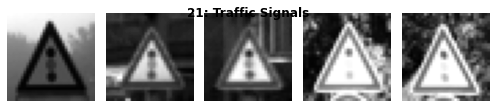

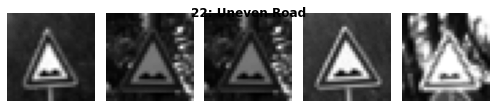

In [30]:
X_train_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train))) 
show_random_dataset_images(X_train_group_by_label, X_train_grayscale)

In [31]:
X_valid_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_val))) 

In [32]:
X_test_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_test))) 


In [33]:
class ModelConfig:


    def __init__(self, model, name, input_img_dimensions, conv_layers_config, fc_output_dims, output_classes, dropout_keep_pct):
        self.model = model
        self.name=name
        self.input_img_dimensions = input_img_dimensions
        
        # Determines the wxh dimension of filters, the starting depth (increases by x2 at every layer) 
        # and how many convolutional layers the network has
        self.conv_filter_size = conv_layers_config[0]
        self.conv_depth_start = conv_layers_config[1]
        self.conv_layers_count = conv_layers_config[2]


        self.fc_output_dims = fc_output_dims 
        self.output_classes = output_classes

        # Try with different values for drop out at convolutional and fully connected layers
        self.dropout_conv_keep_pct = dropout_keep_pct[0]
        self.dropout_fc_keep_pct = dropout_keep_pct[1]

In [34]:
class ModelExecutor:

    def __init__(self, model_config, learning_rate=0.001):
        self.model_config = model_config
        self.learning_rate = learning_rate
    
        self.graph = tf.Graph()
        with self.graph.as_default() as g:
            with g.name_scope( self.model_config.name ) as scope:
                # Create Model operations
                self.create_model_operations()

                # Create a saver to persist the results of execution
                self.saver = tf.train.Saver()
    
    def create_placeholders(self):


        input_dims = self.model_config.input_img_dimensions
        self.x = tf.placeholder(tf.float32, (None, input_dims[0], input_dims[1], input_dims[2]), name="{0}_x".format(self.model_config.name))
        self.y = tf.placeholder(tf.int32, (None), name="{0}_y".format(self.model_config.name))
        self.one_hot_y = tf.one_hot(self.y, self.model_config.output_classes)

        self.dropout_placeholder_conv = tf.placeholder(tf.float32)
        self.dropout_placeholder_fc = tf.placeholder(tf.float32)

    
    def create_model_operations(self):
        """
        Sets up all operations needed to execute run deep learning pipeline
        """

        # First step is to set our x, y, etc
        self.create_placeholders()

        cnn = self.model_config.model

        # Build the network -  TODO: pass the configuration in the future
        self.logits = cnn(self.x, self.model_config, self.dropout_placeholder_conv, self.dropout_placeholder_fc)
        # Obviously, using softmax as the activation function for final layer
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y, logits=self.logits)
        # Combined all the losses across batches
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        # What method do we use to reduce our loss?
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        # What do we really do in a training operation then? Answer: we attempt to reduce the loss using our chosen optimizer
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Get the top prediction for model against labels and check whether they match
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        # Compute accuracy at batch level
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # compute what the prediction would be, when we don't have matching label
        self.prediction = tf.argmax(self.logits, 1)
        # Registering our top 5 predictions
        self.top5_predictions = tf.nn.top_k(tf.nn.softmax(self.logits), k=5, sorted=True, name=None)

        
    def evaluate_model(self, X_data, Y_data, batch_size):
        """
        Evaluates the model's accuracy and loss for the supplied dataset. 
        Naturally, Dropout is ignored in this case (i.e. we set dropout_keep_pct to 1.0)
        """
        
        num_examples = len(X_data)
        total_accuracy = 0.0
        total_loss = 0.0
        sess = tf.get_default_session()

        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = X_data[offset:offset+batch_size], Y_data[offset:offset+batch_size]
            
            # Compute both accuracy and loss for this batch
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={
                                    self.dropout_placeholder_conv: 1.0,
                                    self.dropout_placeholder_fc: 1.0,
                                    self.x: batch_x, 
                                    self.y: batch_y
                                           })
            loss = sess.run(self.loss_operation, feed_dict={
                                    self.dropout_placeholder_conv: 1.0,
                                    self.dropout_placeholder_fc: 1.0,
                                    self.x: batch_x, 
                                    self.y: batch_y
                                           })

            # Weighting accuracy by the total number of elements in batch
            total_accuracy += (accuracy * len(batch_x))        
            total_loss += (loss * len(batch_x))            

        # To produce a true mean accuracy over whole dataset
        return (total_accuracy / num_examples, total_loss / num_examples) 
    
    
    def train_model(self, X_train_features, X_train_labels, X_valid_features, y_valid_labels, batch_size=512, epochs=50, PRINT_FREQ=10):
        """
        Trains the model for the specified number of epochs supplied when creating the executor
        """

        # Create our array of metrics    
        training_metrics = np.zeros((epochs, 3))
        validation_metrics = np.zeros((epochs, 3))


        with tf.Session(graph = self.graph, config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:            
            
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train_features)


            print("Training {0} [epochs={1}, batch_size={2}]...\n".format(self.model_config.name, epochs, batch_size))

            for i in range(epochs):
                start = time.time()
                X_train, Y_train = shuffle(X_train_features, X_train_labels)
                for offset in range(0, num_examples, batch_size):
                    end = offset + batch_size
                    batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
                    sess.run(self.training_operation, feed_dict={
                        self.x: batch_x, 
                        self.y: batch_y, 
                        self.dropout_placeholder_conv: self.model_config.dropout_conv_keep_pct,
                        self.dropout_placeholder_fc: self.model_config.dropout_fc_keep_pct,

                    })

                end_training_time = time.time()
                training_duration = end_training_time - start

                #computing training accuracy
                training_accuracy, training_loss = self.evaluate_model(X_train_features, X_train_labels, batch_size)            


                # Computing validation accuracy 
                validation_accuracy, validation_loss = self.evaluate_model(X_valid_features, y_valid_labels, batch_size)


                end_epoch_time = time.time()            
                validation_duration = end_epoch_time - end_training_time   
                epoch_duration = end_epoch_time - start

                if i == 0 or (i+1) % PRINT_FREQ == 0:
                    print("[{0}]\ttotal={1:.3f}s | train: time={2:.3f}s, loss={3:.4f}, acc={4:.4f} | val: time={5:.3f}s, loss={6:.4f}, acc={7:.4f}".format(
                          i+1, epoch_duration, training_duration, training_loss, training_accuracy, 
                        validation_duration, validation_loss, validation_accuracy))

                training_metrics[i] = [training_duration, training_loss, training_accuracy]
                validation_metrics[i] = [validation_duration, validation_loss, validation_accuracy]

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            # Save the model
            self.saver.save(sess, model_file_name)
            print("Model {0} saved".format(model_file_name))

        return (training_metrics, validation_metrics, epoch_duration)
    
    def test_model(self, test_imgs, test_lbs, batch_size=512):
        """
        Evaluates the model with the test dataset and test labels
        Returns the tuple (test_accuracy, test_loss, duration)
        """

        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()

            
            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)

            start = time.time()
            (test_accuracy, test_loss) = self.evaluate_model(test_imgs, test_lbs, batch_size)
            duration = time.time() - start
            print("[{0} - Test Set]\ttime={1:.3f}s, loss={2:.4f}, acc={3:.4f}".format(self.model_config.name, duration, test_loss, test_accuracy))

        
        return (test_accuracy, test_loss, duration)
    
    def predict(self, imgs, top_5=False):
        """
        Returns the predictions associated with a bunch of images
        """
        preds = None
        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            if top_5:
                preds = sess.run(self.top5_predictions, feed_dict={
                        self.x: imgs,
                        self.dropout_placeholder_conv: 1.0,
                        self.dropout_placeholder_fc: 1.0
                    })
            else:
                preds = sess.run(self.prediction, feed_dict={
                    self.x: imgs,
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })
    
        return preds
    
    def show_conv_feature_maps(self, img, conv_layer_idx=0, activation_min=-1, activation_max=-1 ,
                               plt_num=1, fig_size=(15, 15), title_y_pos=1.0):
        """
        Shows the resulting feature maps at a given convolutional level for a SINGLE image
        """
        #s = tf.train.Saver()
        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()
            #tf.reset_default_graph()

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            # Run a prediction
            preds = sess.run(self.prediction, feed_dict={
                    self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })

            
            var_name = "{0}/conv_{1}_relu:0".format(self.model_config.name, conv_layer_idx)
            print("Fetching tensor: {0}".format(var_name))
            conv_layer = tf.get_default_graph().get_tensor_by_name(var_name)
            
            activation = sess.run(conv_layer, feed_dict={
                            self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                            self.dropout_placeholder_conv: 1.0,
                            self.dropout_placeholder_fc: 1.0
                            })
            featuremaps = activation.shape[-1]
            # (1, 13, 13, 64)
            print("Shape of activation layer: {0}".format(activation.shape))
            
            #fix the number of columns
            cols = 8
            rows = featuremaps // cols
            fig, axes = plt.subplots(rows, cols, figsize=fig_size)
            k = 0
            for i in range(0, rows):
                for j in range(0, cols):
                    ax = axes[i, j]
                    featuremap = k

                    if activation_min != -1 & activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
                    elif activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
                    elif activation_min !=-1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
                    else:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
                    
                    ax.axis("off")
                    k += 1
            
            fig.suptitle("Feature Maps at layer: {0}".format(conv_layer), fontsize=12, fontweight='bold', y=title_y_pos)
            fig.tight_layout()
            plt.show()

In [35]:

def Traffic_Net(x, mc, dropout_conv_pct, dropout_fc_pct):
    """
    A variant of LeNet created by Yann Le Cun
    The second parameter, which is encapsulates model configuration, enables varying the convolution filter sizes 
    as well as the number of fully connected layers and their output dimensions.
    The third and fourth parameters represent dropout placeholders for convolutional and fully connected layers respectively
    """
    
    # Used for randomly definining weights and biases
    mu = 0
    sigma = 0.1
    
    prev_conv_layer = x
    conv_depth = mc.conv_depth_start
    conv_input_depth = mc.input_img_dimensions[-1]
   
    print("[Traffic_Net] Building neural network [conv layers={0}, conv filter size={1}, conv start depth={2}, fc layers={3}]".format(
        mc.conv_layers_count, mc.conv_filter_size, conv_depth, len(mc.fc_output_dims)))
    
    for i in range(0, mc.conv_layers_count):
        # layer depth grows exponentially
        conv_output_depth = conv_depth * (2 ** (i))
        conv_W = tf.Variable(tf.truncated_normal(shape=(mc.conv_filter_size, mc.conv_filter_size, conv_input_depth, conv_output_depth), 
                                              mean = mu, stddev = sigma))
        conv_b = tf.Variable(tf.zeros(conv_output_depth))
        
        conv_output = tf.nn.conv2d(prev_conv_layer, conv_W, strides=[1, 1, 1, 1], padding='VALID', name="conv_{0}".format(i)) + conv_b
        conv_output = tf.nn.relu(conv_output, name="conv_{0}_relu".format(i))
        # Traditional max 2x2 pool 
        conv_output = tf.nn.max_pool(conv_output, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        # Apply dropout - even at the conv level
        conv_output = tf.nn.dropout(conv_output, dropout_conv_pct) 
        
        # Setting our loop variables accordingly
        prev_conv_layer = conv_output
        conv_input_depth = conv_output_depth

    
    # Flatten results of second convolutional layer so that it can be supplied to fully connected layer
    fc0   = Flatten()(prev_conv_layer)
    
    # Now creating our fully connected layers
    prev_layer = fc0
    for output_dim in mc.fc_output_dims:
        fcn_W  = tf.Variable(tf.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], output_dim), 
                                                 mean = mu, stddev = sigma))
        fcn_b  = tf.Variable(tf.zeros(output_dim))
        
        prev_layer   = tf.nn.dropout(tf.nn.relu(tf.matmul(prev_layer, fcn_W) + fcn_b), dropout_fc_pct)

    
    # Final layer (Fully Connected)
    fc_final_W  = tf.Variable(tf.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], mc.output_classes), 
                                                  mean = mu, stddev = sigma))
    fc_final_b  = tf.Variable(tf.zeros(mc.output_classes))
    logits = tf.matmul(prev_layer, fc_final_W) + fc_final_b
    
    return logits


In [36]:
mc_3x3 = ModelConfig(Traffic_Net, "Traffic_Net_3x3_Color_Sample", [32, 32, 3], [3, 16, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(Traffic_Net, "Traffic_Net_5x5_Color_Sample", [32, 32, 3], [5, 16, 2], [120, 84], n_classes, [1.0, 1.0])
mc_7x7 = ModelConfig(Traffic_Net, "Traffic_Net_7x7_Color_Sample", [32, 32, 3], [7, 16, 2], [120, 84], n_classes, [1.0, 1.0])

In [37]:
device_name=tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError("No GPU Found")
print('Found GPU at :{}'.format(device_name))

Found GPU at :/device:GPU:0


In [38]:
me_c_sample_3x3 = ModelExecutor(mc_3x3)
me_c_sample_5x5 = ModelExecutor(mc_5x5)
me_c_sample_7x7 = ModelExecutor(mc_7x7)

[Traffic_Net] Building neural network [conv layers=3, conv filter size=3, conv start depth=16, fc layers=2]
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[Traffic_Net] Building neural network [conv layers=2, conv filter size=5, conv start depth=16, fc layers=2]
[Traffic_Net] Building neural network [conv layers=2, conv filter size=7, conv start depth=16, fc layers=2]


In [41]:
with tf.device('/gpu:0'):
  (c_sample_3x3_tr_metrics, c_sample_3x3_val_metrics, c_sample_3x3_duration) = me_c_sample_3x3.train_model(X_train, y_train, X_val, y_val, epochs=50)
  (c_sample_3x3_ts_accuracy, c_sample_3x3_ts_loss, c_sample_3x3_ts_duration) =  me_c_sample_3x3.test_model(X_test, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_3x3_Color_Sample [epochs=50, batch_size=512]...

[1]	total=1.163s | train: time=0.650s, loss=2.6532, acc=0.2279 | val: time=0.512s, loss=2.6799, acc=0.2243
[10]	total=0.736s | train: time=0.345s, loss=0.3059, acc=0.9147 | val: time=0.390s, loss=0.4022, acc=0.8867
[20]	total=0.735s | train: time=0.348s, loss=0.0547, acc=0.9868 | val: time=0.387s, loss=0.2228, acc=0.9407
[30]	total=0.740s | train: time=0.341s, loss=0.0114, acc=0.9992 | val: time=0.399s, loss=0.1680, acc=0.9633
[40]	total=0.750s | train: time=0.360s, loss=0.0160, acc=0.9969 | val: time=0.390s, loss=0.1677, acc=0.9606
[50]	total=0.749s | train: time=0.349s, loss=0.0018, acc=1.0000 | val: time=0.400s, loss=0.1539, acc=0.9710
Model ./models/Traffic_Net_3x3_Color_Sample.chkpt saved
INFO:tensorflow:Restoring parameters from ./models/Traffic_Net_3x3_Color_Sample.chkpt

In [42]:
with tf.device('/gpu:0'):
  (c_sample_5x5_tr_metrics, c_sample_5x5_val_metrics, c_sample_5x5_duration) = me_c_sample_5x5.train_model(X_train, y_train, X_val, y_val, epochs=50)
  (c_sample_5x5_ts_accuracy, c_sample_5x5_ts_loss, c_sample_5x5_ts_duration) =  me_c_sample_5x5.test_model(X_test, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_5x5_Color_Sample [epochs=50, batch_size=512]...

[1]	total=1.053s | train: time=0.594s, loss=4.0696, acc=0.1592 | val: time=0.459s, loss=4.2208, acc=0.1498
[10]	total=0.689s | train: time=0.313s, loss=0.3334, acc=0.8982 | val: time=0.376s, loss=0.5579, acc=0.8510
[20]	total=0.697s | train: time=0.315s, loss=0.0654, acc=0.9835 | val: time=0.382s, loss=0.3716, acc=0.9218
[30]	total=0.714s | train: time=0.328s, loss=0.0161, acc=0.9977 | val: time=0.386s, loss=0.3320, acc=0.9401
[40]	total=0.700s | train: time=0.318s, loss=0.0043, acc=0.9999 | val: time=0.383s, loss=0.3538, acc=0.9457
[50]	total=0.695s | train: time=0.320s, loss=0.0019, acc=1.0000 | val: time=0.375s, loss=0.3785, acc=0.9508
Model ./models/Traffic_Net_5x5_Color_Sample.chkpt saved
INFO:tensorflow:Restoring parameters from ./models/Traffic_Net_5x5_Color_Sample.chkpt

Grayscale



In [43]:
X_train_grayscale = np.reshape(X_train_grayscale, (X_train_grayscale.shape[0], 32, 32, 1))
X_valid_grayscale = np.reshape(X_valid_grayscale, (X_valid_grayscale.shape[0], 32, 32, 1))
X_test_grayscale = np.reshape(X_test_grayscale, (X_test_grayscale.shape[0], 32, 32, 1))

In [44]:
with tf.device('/gpu:0'):
  mc_3x3 = ModelConfig(Traffic_Net, "Traffic_Net_Grayscale_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
  mc_5x5 = ModelConfig(Traffic_Net, "Traffic_Net_Grayscale_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [45]:
me_g_3x3 = ModelExecutor(mc_3x3)
me_g_5x5 = ModelExecutor(mc_5x5)

[Traffic_Net] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[Traffic_Net] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [48]:
with tf.device('/gpu:0'):
  (g_3x3_tr_metrics, g_3x3_val_metrics, g_3x3_duration) = me_g_3x3.train_model(X_train_grayscale, y_train, X_valid_grayscale, y_val, epochs=1000)
  (g_3x3_ts_accuracy, g_3x3_ts_loss, g_3x3_ts_duration) =  me_g_3x3.test_model(X_test_grayscale, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Grayscale_3x3 [epochs=1000, batch_size=512]...

[1]	total=1.167s | train: time=0.661s, loss=2.8506, acc=0.1909 | val: time=0.507s, loss=2.8708, acc=0.1921
[10]	total=0.931s | train: time=0.484s, loss=0.2583, acc=0.9385 | val: time=0.447s, loss=0.3751, acc=0.9088
[20]	total=0.942s | train: time=0.485s, loss=0.0537, acc=0.9902 | val: time=0.457s, loss=0.2069, acc=0.9556
[30]	total=0.944s | train: time=0.483s, loss=0.0156, acc=0.9989 | val: time=0.461s, loss=0.1894, acc=0.9649
[40]	total=0.940s | train: time=0.487s, loss=0.0058, acc=0.9999 | val: time=0.453s, loss=0.1706, acc=0.9721
[50]	total=0.935s | train: time=0.482s, loss=0.0025, acc=1.0000 | val: time=0.453s, loss=0.1725, acc=0.9750
[60]	total=0.933s | train: time=0.483s, loss=0.0014, acc=1.0000 | val: time=0.450s, loss=0.1851, acc=0.9726
[70]	total=0.929s | train: time=0.

In [50]:
(g_5x5_tr_metrics, g_5x5_val_metrics, g_5x5_duration) = me_g_5x5.train_model(X_train_grayscale, y_train, X_valid_grayscale, y_val, epochs=100)
(g_5x5_ts_accuracy, g_5x5_ts_loss, g_5x5_ts_duration) =  me_g_5x5.test_model(X_test_grayscale, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Grayscale_5x5 [epochs=100, batch_size=512]...

[1]	total=1.387s | train: time=0.857s, loss=4.3806, acc=0.1843 | val: time=0.530s, loss=4.4311, acc=0.1838
[10]	total=0.877s | train: time=0.432s, loss=0.1854, acc=0.9524 | val: time=0.445s, loss=0.4351, acc=0.9013
[20]	total=0.868s | train: time=0.432s, loss=0.0251, acc=0.9970 | val: time=0.436s, loss=0.3189, acc=0.9495
[30]	total=0.865s | train: time=0.429s, loss=0.0058, acc=0.9998 | val: time=0.436s, loss=0.3147, acc=0.9590
[40]	total=0.863s | train: time=0.429s, loss=0.0021, acc=0.9999 | val: time=0.434s, loss=0.3377, acc=0.9593
[50]	total=0.856s | train: time=0.426s, loss=0.0011, acc=0.9999 | val: time=0.430s, loss=0.3529, acc=0.9617
[60]	total=0.859s | train: time=0.427s, loss=0.0006, acc=1.0000 | val: time=0.432s, loss=0.3669, acc=0.9609
[70]	total=0.872s | train: time=0.4

In [52]:
def plot_model_results(metrics, axes, lbs, xlb, ylb, titles, fig_title, fig_size=(7, 5), epochs_interval=10):
    """
    Nifty utility function to plot results of the execution of our model
    """
    fig, axs = plt.subplots(nrows=1, ncols=len(axes), figsize=fig_size)
    print("Length of axis: {0}".format(axs.shape))

    total_epochs = metrics[0].shape[0]
    x_values = np.linspace(1, total_epochs, num=total_epochs, dtype=np.int32)

Length of axis: (2,)


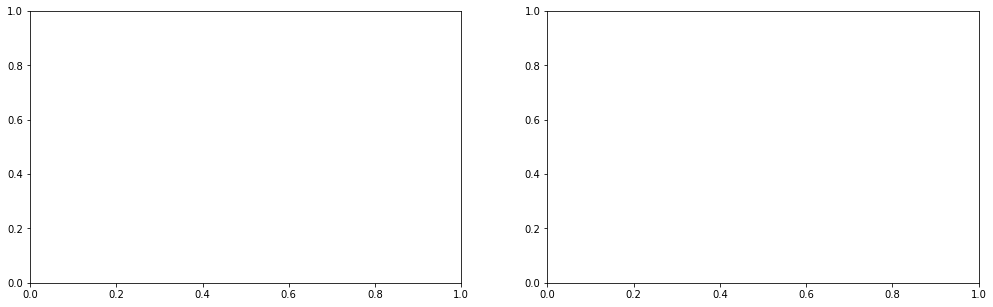

In [55]:
metrics_arr = [g_5x5_tr_metrics, g_5x5_val_metrics, g_3x3_tr_metrics, g_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale  - Accuracy and Loss of models"
                    , fig_size=(17, 5))

In [56]:
mc_3x3 = ModelConfig(Traffic_Net, "Traffic_Net_Color_Norm_3x3", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(Traffic_Net, "Traffic_Net_Color_Norm_5x5", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [57]:
me_c_norm_3x3 = ModelExecutor(mc_3x3)
me_c_norm_5x5 = ModelExecutor(mc_5x5)

[Traffic_Net] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[Traffic_Net] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [59]:
(c_norm_3x3_tr_metrics, c_norm_3x3_val_metrics, c_norm_3x3_duration) = me_c_norm_3x3.train_model(X_train_normalised, y_train, X_valid_normalised, y_val, epochs=100)
(c_norm_3x3_ts_accuracy, c_norm_3x3_ts_loss, c_norm_3x3_ts_duration) =  me_c_norm_3x3.test_model(X_test_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Color_Norm_3x3 [epochs=100, batch_size=512]...

[1]	total=1.746s | train: time=1.036s, loss=2.0570, acc=0.3459 | val: time=0.711s, loss=2.0814, acc=0.3440
[10]	total=1.315s | train: time=0.669s, loss=0.0599, acc=0.9904 | val: time=0.646s, loss=0.1113, acc=0.9766
[20]	total=1.328s | train: time=0.674s, loss=0.0091, acc=0.9995 | val: time=0.654s, loss=0.0719, acc=0.9854
[30]	total=1.325s | train: time=0.676s, loss=0.0031, acc=0.9999 | val: time=0.648s, loss=0.0740, acc=0.9878
[40]	total=1.318s | train: time=0.676s, loss=0.0371, acc=0.9914 | val: time=0.642s, loss=0.0922, acc=0.9785
[50]	total=1.309s | train: time=0.673s, loss=0.0010, acc=1.0000 | val: time=0.636s, loss=0.0638, acc=0.9896
[60]	total=1.314s | train: time=0.670s, loss=0.0005, acc=1.0000 | val: time=0.645s, loss=0.0677, acc=0.9891
[70]	total=1.325s | train: time=0.

In [61]:
(c_norm_5x5_tr_metrics, c_norm_5x5_val_metrics, c_norm_5x5_duration) = me_c_norm_5x5.train_model(X_train_normalised, y_train, X_valid_normalised, y_val, epochs=100)
(c_norm_5x5_ts_accuracy, c_norm_5x5_ts_loss, c_norm_5x5_ts_duration) =  me_c_norm_5x5.test_model(X_test_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Color_Norm_5x5 [epochs=100, batch_size=512]...

[1]	total=1.660s | train: time=0.981s, loss=1.7388, acc=0.4454 | val: time=0.679s, loss=1.7664, acc=0.4328
[10]	total=1.218s | train: time=0.606s, loss=0.0383, acc=0.9943 | val: time=0.612s, loss=0.1034, acc=0.9785
[20]	total=1.224s | train: time=0.612s, loss=0.0066, acc=0.9997 | val: time=0.612s, loss=0.0784, acc=0.9851
[30]	total=1.218s | train: time=0.609s, loss=0.0023, acc=0.9999 | val: time=0.609s, loss=0.0816, acc=0.9854
[40]	total=1.215s | train: time=0.609s, loss=0.0010, acc=1.0000 | val: time=0.605s, loss=0.0849, acc=0.9859
[50]	total=1.234s | train: time=0.609s, loss=0.0005, acc=1.0000 | val: time=0.625s, loss=0.0870, acc=0.9859
[60]	total=1.214s | train: time=0.604s, loss=0.0003, acc=1.0000 | val: time=0.609s, loss=0.0903, acc=0.9862
[70]	total=1.215s | train: time=0.

In [63]:
X_train_grayscale_normalised = normalise_images(X_train_grayscale, X_train_grayscale)
X_valid_grayscale_normalised = normalise_images(X_valid_grayscale, X_train_grayscale)
X_test_grayscale_normalised = normalise_images(X_test_grayscale, X_train_grayscale)

In [64]:
mc_3x3 = ModelConfig(Traffic_Net, "Traffic_Net_Grayscale_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(Traffic_Net, "Traffic_Net_Grayscale_Norm_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [65]:
me_g_norm_3x3 = ModelExecutor(mc_3x3)
me_g_norm_5x5 = ModelExecutor(mc_5x5)

[Traffic_Net] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[Traffic_Net] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [67]:
(g_norm_3x3_tr_metrics, g_norm_3x3_val_metrics, g_norm_3x3_duration) = me_g_norm_3x3.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_val, epochs=100)
(g_norm_3x3_ts_accuracy, g_norm_3x3_ts_loss, g_norm_3x3_ts_duration) =  me_g_norm_3x3.test_model(X_test_grayscale_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Grayscale_Norm_3x3 [epochs=100, batch_size=512]...

[1]	total=1.201s | train: time=0.665s, loss=2.3125, acc=0.3079 | val: time=0.536s, loss=2.3467, acc=0.2918
[10]	total=0.982s | train: time=0.510s, loss=0.1170, acc=0.9717 | val: time=0.472s, loss=0.2005, acc=0.9540
[20]	total=0.992s | train: time=0.520s, loss=0.0168, acc=0.9979 | val: time=0.471s, loss=0.1024, acc=0.9787
[30]	total=0.992s | train: time=0.517s, loss=0.0062, acc=0.9995 | val: time=0.476s, loss=0.0882, acc=0.9835
[40]	total=0.992s | train: time=0.512s, loss=0.0017, acc=1.0000 | val: time=0.480s, loss=0.0989, acc=0.9848
[50]	total=0.988s | train: time=0.512s, loss=0.0009, acc=1.0000 | val: time=0.475s, loss=0.1047, acc=0.9848
[60]	total=0.988s | train: time=0.509s, loss=0.0005, acc=1.0000 | val: time=0.479s, loss=0.1106, acc=0.9854
[70]	total=0.986s | train: tim

In [68]:
(g_norm_5x5_tr_metrics, g_norm_5x5_val_metrics, g_norm_5x5_duration) = me_g_norm_5x5.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_val, epochs=100)
(g_norm_5x5_ts_accuracy, g_norm_5x5_ts_loss, g_norm_5x5_ts_duration) =  me_g_norm_5x5.test_model(X_test_grayscale_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Grayscale_Norm_5x5 [epochs=100, batch_size=512]...

[1]	total=1.113s | train: time=0.590s, loss=1.7066, acc=0.4985 | val: time=0.523s, loss=1.7410, acc=0.4914
[10]	total=0.916s | train: time=0.467s, loss=0.0630, acc=0.9864 | val: time=0.450s, loss=0.1313, acc=0.9734
[20]	total=0.934s | train: time=0.468s, loss=0.0120, acc=0.9988 | val: time=0.466s, loss=0.0761, acc=0.9843
[30]	total=0.948s | train: time=0.469s, loss=0.0036, acc=0.9999 | val: time=0.479s, loss=0.0805, acc=0.9864
[40]	total=0.934s | train: time=0.464s, loss=0.0015, acc=0.9999 | val: time=0.470s, loss=0.0840, acc=0.9862
[50]	total=0.935s | train: time=0.468s, loss=0.0008, acc=1.0000 | val: time=0.468s, loss=0.0883, acc=0.9867
[60]	total=0.934s | train: time=0.465s, loss=0.0005, acc=1.0000 | val: time=0.469s, loss=0.0951, acc=0.9862
[70]	total=0.925s | train: tim

Drop out

In [70]:
mc_3x3 = ModelConfig(Traffic_Net, "Traffic_Net_3x3_Color_Dropout_0.75", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [0.9, 0.75])
mc_5x5 = ModelConfig(Traffic_Net, "Traffic_Net_3x3_Color_Dropout_0.75", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [0.9, 0.75])

In [71]:
me_c_norm_drpt_0_75_3x3 = ModelExecutor(mc_3x3)
me_c_norm_drpt_0_75_5x5 = ModelExecutor(mc_5x5)

[Traffic_Net] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[Traffic_Net] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [72]:
(c_norm_drpt_0_75_3x3_tr_metrics, c_norm_drpt_0_75_3x3_val_metrics, c_norm_drpt_0_75_3x3_duration) = me_c_norm_drpt_0_75_3x3.train_model(X_train_normalised, y_train, X_valid_normalised, y_val, epochs=100)
(_c_norm_drpt_0_75_3x3_ts_accuracy, c_norm_drpt_0_75_3x3_ts_loss, c_norm_drpt_0_75_ts_duration) =  me_c_norm_drpt_0_75_3x3.test_model(X_test_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_3x3_Color_Dropout_0.75 [epochs=100, batch_size=512]...

[1]	total=1.541s | train: time=0.832s, loss=2.5671, acc=0.2064 | val: time=0.709s, loss=2.5837, acc=0.2056
[10]	total=1.318s | train: time=0.677s, loss=0.0843, acc=0.9836 | val: time=0.641s, loss=0.1042, acc=0.9763
[20]	total=1.301s | train: time=0.667s, loss=0.0089, acc=0.9987 | val: time=0.634s, loss=0.0269, acc=0.9939
[30]	total=1.307s | train: time=0.670s, loss=0.0025, acc=0.9999 | val: time=0.638s, loss=0.0211, acc=0.9944
[40]	total=1.303s | train: time=0.673s, loss=0.0015, acc=0.9998 | val: time=0.631s, loss=0.0205, acc=0.9944
[50]	total=1.304s | train: time=0.674s, loss=0.0007, acc=0.9999 | val: time=0.631s, loss=0.0212, acc=0.9949
[60]	total=1.295s | train: time=0.665s, loss=0.0004, acc=0.9999 | val: time=0.630s, loss=0.0162, acc=0.9960
[70]	total=1.304s | train:

In [73]:
(c_norm_drpt_0_75_5x5_tr_metrics, c_norm_drpt_0_75_5x5_val_metrics, c_norm_drpt_0_75_5x5_duration) = me_c_norm_drpt_0_75_5x5.train_model(X_train_normalised, y_train, X_valid_normalised, y_val, epochs=100)
(c_norm_drpt_0_75_5x5_ts_accuracy, c_norm_drpt_0_75_5x5_ts_loss, c_norm_drpt_0_75_5x5_ts_duration) =  me_c_norm_drpt_0_75_5x5.test_model(X_test_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_3x3_Color_Dropout_0.75 [epochs=100, batch_size=512]...

[1]	total=1.408s | train: time=0.746s, loss=2.3579, acc=0.3124 | val: time=0.661s, loss=2.3689, acc=0.3105
[10]	total=1.203s | train: time=0.612s, loss=0.0674, acc=0.9872 | val: time=0.591s, loss=0.0940, acc=0.9779
[20]	total=1.210s | train: time=0.608s, loss=0.0140, acc=0.9981 | val: time=0.602s, loss=0.0390, acc=0.9936
[30]	total=1.212s | train: time=0.604s, loss=0.0038, acc=0.9994 | val: time=0.608s, loss=0.0280, acc=0.9933
[40]	total=1.207s | train: time=0.605s, loss=0.0016, acc=0.9998 | val: time=0.602s, loss=0.0253, acc=0.9952
[50]	total=1.199s | train: time=0.604s, loss=0.0007, acc=0.9999 | val: time=0.596s, loss=0.0236, acc=0.9960
[60]	total=1.208s | train: time=0.608s, loss=0.0006, acc=1.0000 | val: time=0.600s, loss=0.0243, acc=0.9957
[70]	total=1.208s | train:

Drop out Gray scale

In [74]:
mc_3x3 = ModelConfig(Traffic_Net, "Traffic_Net_Grayscale_Norm_3x3_Dropout_0.75", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.9, 0.75])
mc_5x5 = ModelConfig(Traffic_Net, "Traffic_Net_Grayscale_Norm_5x5_Dropout_0.75", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [0.9, 0.75])

In [75]:
me_g_norm_drpt_0_75_3x3 = ModelExecutor(mc_3x3)
me_g_norm_drpt_0_75_5x5 = ModelExecutor(mc_5x5)

[Traffic_Net] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[Traffic_Net] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [76]:
(g_norm_drpt_0_75_3x3_tr_metrics, g_norm_drpt_0_75_3x3_val_metrics, g_norm_drpt_0_75_3x3_duration) = me_g_norm_drpt_0_75_3x3.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_val, epochs=100)
(g_norm_drpt_0_75_3x3_ts_accuracy, g_norm_drpt_0_75_3x3_ts_loss, g_norm_drpt_0_75_ts_3x3_duration) =  me_g_norm_drpt_0_75_3x3.test_model(X_test_grayscale_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Grayscale_Norm_3x3_Dropout_0.75 [epochs=100, batch_size=512]...

[1]	total=1.223s | train: time=0.686s, loss=2.7173, acc=0.1612 | val: time=0.537s, loss=2.7343, acc=0.1572
[10]	total=0.995s | train: time=0.521s, loss=0.0920, acc=0.9816 | val: time=0.474s, loss=0.1189, acc=0.9739
[20]	total=0.988s | train: time=0.513s, loss=0.0124, acc=0.9985 | val: time=0.475s, loss=0.0441, acc=0.9883
[30]	total=1.008s | train: time=0.518s, loss=0.0040, acc=0.9996 | val: time=0.491s, loss=0.0368, acc=0.9915
[40]	total=0.985s | train: time=0.513s, loss=0.0016, acc=0.9998 | val: time=0.472s, loss=0.0337, acc=0.9920
[50]	total=0.989s | train: time=0.517s, loss=0.0006, acc=1.0000 | val: time=0.472s, loss=0.0315, acc=0.9928
[60]	total=0.982s | train: time=0.511s, loss=0.0003, acc=1.0000 | val: time=0.471s, loss=0.0298, acc=0.9933
[70]	total=0.988s

In [77]:
(g_norm_drpt_0_75_5x5_tr_metrics, g_norm_drpt_0_75_5x5_val_metrics, g_norm_drpt_0_75_5x5_duration) = me_g_norm_drpt_0_75_5x5.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_val, epochs=100)
(g_norm_drpt_0_75_5x5_ts_accuracy, g_norm_drpt_0_75_5x5_ts_loss, g_norm_drpt_0_75_ts_5x5_duration) =  me_g_norm_drpt_0_75_5x5.test_model(X_test_grayscale_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Grayscale_Norm_5x5_Dropout_0.75 [epochs=100, batch_size=512]...

[1]	total=1.143s | train: time=0.616s, loss=2.2908, acc=0.3264 | val: time=0.527s, loss=2.3149, acc=0.3203
[10]	total=0.951s | train: time=0.465s, loss=0.0775, acc=0.9830 | val: time=0.486s, loss=0.1137, acc=0.9739
[20]	total=0.927s | train: time=0.464s, loss=0.0150, acc=0.9969 | val: time=0.464s, loss=0.0538, acc=0.9888
[30]	total=0.932s | train: time=0.466s, loss=0.0051, acc=0.9989 | val: time=0.466s, loss=0.0455, acc=0.9912
[40]	total=0.931s | train: time=0.464s, loss=0.0020, acc=0.9997 | val: time=0.466s, loss=0.0396, acc=0.9928
[50]	total=0.928s | train: time=0.460s, loss=0.0012, acc=0.9999 | val: time=0.467s, loss=0.0435, acc=0.9918
[60]	total=0.924s | train: time=0.462s, loss=0.0007, acc=0.9999 | val: time=0.462s, loss=0.0389, acc=0.9923
[70]	total=0.925s

In [78]:
mc_3x3 = ModelConfig(Traffic_Net, "Traffic_Net_Norm_Grayscale_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.75, 0.5])
mc_5x5 = ModelConfig(Traffic_Net, "Traffic_Net_Norm_Grayscale_5x5_Dropout_0.50", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [0.75, 0.5])  

In [79]:
me_g_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3)
me_g_norm_drpt_0_50_5x5 = ModelExecutor(mc_5x5)

[Traffic_Net] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[Traffic_Net] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [80]:
(g_norm_drpt_0_50_3x3_tr_metrics, g_norm_drpt_0_50_3x3_val_metrics, g_norm_drpt_0_50_3x3_duration) = me_g_norm_drpt_0_50_3x3.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_val , epochs=100)
(g_norm_drpt_0_50_3x3_ts_accuracy, g_norm_drpt_0_50_3x3_ts_loss, g_norm_drpt_0_50_ts_3x3_duration) =  me_g_norm_drpt_0_50_3x3.test_model(X_test_grayscale_normalised, y_test) 

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Norm_Grayscale_3x3_Dropout_0.50 [epochs=100, batch_size=512]...

[1]	total=1.204s | train: time=0.665s, loss=2.9489, acc=0.1481 | val: time=0.538s, loss=2.9556, acc=0.1431
[10]	total=1.002s | train: time=0.517s, loss=0.9841, acc=0.6735 | val: time=0.485s, loss=1.0111, acc=0.6560
[20]	total=0.992s | train: time=0.515s, loss=0.1592, acc=0.9590 | val: time=0.478s, loss=0.1745, acc=0.9532
[30]	total=0.990s | train: time=0.516s, loss=0.0462, acc=0.9912 | val: time=0.474s, loss=0.0600, acc=0.9880
[40]	total=0.995s | train: time=0.515s, loss=0.0219, acc=0.9954 | val: time=0.480s, loss=0.0352, acc=0.9928
[50]	total=0.982s | train: time=0.509s, loss=0.0103, acc=0.9982 | val: time=0.472s, loss=0.0226, acc=0.9944
[60]	total=0.980s | train: time=0.508s, loss=0.0054, acc=0.9990 | val: time=0.472s, loss=0.0192, acc=0.9941
[70]	total=0.981s

In [82]:
(g_norm_drpt_0_50_5x5_tr_metrics, g_norm_drpt_0_50_5x5_val_metrics, g_norm_drpt_0_50_5x5_duration) = me_g_norm_drpt_0_50_5x5.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_val, epochs=100)
(g_norm_drpt_0_50_5x5_ts_accuracy, g_norm_drpt_0_50_5x5_ts_loss, g_norm_drpt_0_50_ts_5x5_duration) =  me_g_norm_drpt_0_50_5x5.test_model(X_test_grayscale_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Norm_Grayscale_5x5_Dropout_0.50 [epochs=100, batch_size=512]...

[1]	total=1.103s | train: time=0.594s, loss=2.8806, acc=0.1334 | val: time=0.509s, loss=2.8879, acc=0.1242
[10]	total=0.927s | train: time=0.464s, loss=0.5851, acc=0.8618 | val: time=0.462s, loss=0.6151, acc=0.8516
[20]	total=0.930s | train: time=0.465s, loss=0.1134, acc=0.9760 | val: time=0.465s, loss=0.1361, acc=0.9723
[30]	total=0.928s | train: time=0.465s, loss=0.0395, acc=0.9916 | val: time=0.463s, loss=0.0647, acc=0.9843
[40]	total=0.924s | train: time=0.464s, loss=0.0215, acc=0.9967 | val: time=0.460s, loss=0.0436, acc=0.9907
[50]	total=0.926s | train: time=0.465s, loss=0.0100, acc=0.9985 | val: time=0.461s, loss=0.0353, acc=0.9918
[60]	total=0.927s | train: time=0.460s, loss=0.0063, acc=0.9988 | val: time=0.467s, loss=0.0309, acc=0.9939
[70]	total=0.934s

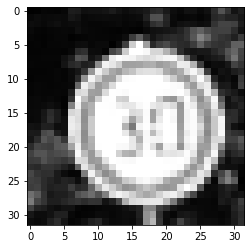

In [88]:
g_img = np.reshape(X_train_grayscale[12001], (32, 32))
plt.imshow(g_img, cmap='gray')

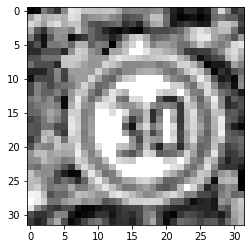

In [90]:
clahe = cv2.createCLAHE(tileGridSize=(4,4), clipLimit=40.0)
cl1 = clahe.apply(g_img)
plt.imshow(cl1, cmap='gray')

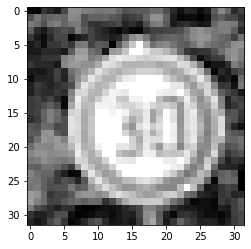

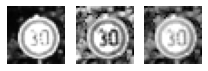

In [91]:
clahe = cv2.createCLAHE(tileGridSize=(2,2), clipLimit=15.0)
cl2 = clahe.apply(g_img)
plt.imshow(cl2, cmap='gray')
show_image_list([g_img, cl1, cl2], ["L0","L1", "l2"], "", cols=3, fig_size=(3, 3), show_ticks=False)

In [92]:
X_train_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_train_grayscale)))
X_valid_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_valid_grayscale)))
X_test_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_test_grayscale)))

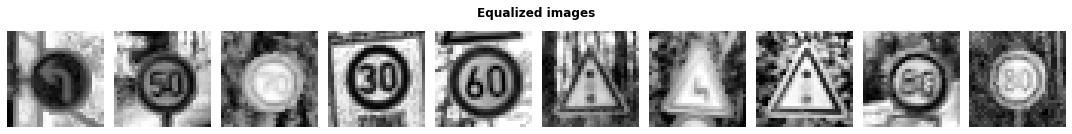

In [93]:

show_image_list(X_train_grayscale_equalized[1640:1650], y_train[1640:1650], "Equalized images", fig_size=(15, 10), cols=10, show_ticks=False)

Model Evaluation

In [94]:
X_train_grayscale_equalized_normalised = normalise_images(X_train_grayscale_equalized, X_train_grayscale_equalized)
X_valid_grayscale_equalized_normalised = normalise_images(X_valid_grayscale_equalized, X_train_grayscale_equalized)
X_test_grayscale_equalized_normalised = normalise_images(X_test_grayscale_equalized, X_train_grayscale_equalized)

In [95]:
X_train_grayscale_equalized = np.reshape(X_train_grayscale_equalized, (X_train_grayscale_equalized.shape[0], 32, 32, 1))
X_valid_grayscale_equalized = np.reshape(X_valid_grayscale_equalized, (X_valid_grayscale_equalized.shape[0], 32, 32, 1))
X_test_grayscale_equalized = np.reshape(X_test_grayscale_equalized, (X_test_grayscale_equalized.shape[0], 32, 32, 1))

X_train_grayscale_equalized_normalised = np.reshape(X_train_grayscale_equalized_normalised, (X_train_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_valid_grayscale_equalized_normalised = np.reshape(X_valid_grayscale_equalized_normalised, (X_valid_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_test_grayscale_equalized_normalised = np.reshape(X_test_grayscale_equalized_normalised, (X_test_grayscale_equalized_normalised.shape[0], 32, 32, 1))

In [96]:
mc_3x3 = ModelConfig(Traffic_Net, "Traffic_Net_Grayscale_CLAHE_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(Traffic_Net, "Traffic_Net_Grayscale_CLAHE_Norm_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [97]:
me_g_clahe_norm_3x3 = ModelExecutor(mc_3x3)
me_g_clahe_norm_5x5 = ModelExecutor(mc_5x5)

[Traffic_Net] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[Traffic_Net] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [99]:
(g_clahe_norm_3x3_tr_metrics, g_clahe_norm_3x3_val_metrics, g_clahe_norm_3x3_duration) = me_g_clahe_norm_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_val, epochs=100)
(g_clahe_norm_3x3_ts_accuracy, g_clahe_norm_3x3_ts_loss, g_clahe_norm_3x3_ts_duration) =  me_g_clahe_norm_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Grayscale_CLAHE_Norm_3x3 [epochs=100, batch_size=512]...

[1]	total=1.221s | train: time=0.683s, loss=2.0739, acc=0.3568 | val: time=0.538s, loss=2.0881, acc=0.3506
[10]	total=0.996s | train: time=0.515s, loss=0.0715, acc=0.9835 | val: time=0.481s, loss=0.1358, acc=0.9601
[20]	total=0.998s | train: time=0.523s, loss=0.0058, acc=1.0000 | val: time=0.475s, loss=0.0740, acc=0.9808
[30]	total=0.986s | train: time=0.518s, loss=0.0016, acc=1.0000 | val: time=0.467s, loss=0.0755, acc=0.9822
[40]	total=0.979s | train: time=0.512s, loss=0.0007, acc=1.0000 | val: time=0.466s, loss=0.0755, acc=0.9824
[50]	total=0.978s | train: time=0.507s, loss=0.0004, acc=1.0000 | val: time=0.471s, loss=0.0791, acc=0.9814
[60]	total=0.976s | train: time=0.509s, loss=0.0002, acc=1.0000 | val: time=0.467s, loss=0.0796, acc=0.9843
[70]	total=0.978s | trai

In [101]:

(g_clahe_norm_5x5_tr_metrics, g_clahe_norm_5x5_val_metrics, g_clahe_norm_5x5_duration) = me_g_clahe_norm_5x5.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_val, epochs=100)
(g_clahe_norm_5x5_ts_accuracy, g_clahe_norm_5x5_ts_loss, g_clahe_norm_5x5_ts_duration) =  me_g_clahe_norm_5x5.test_model(X_test_grayscale_equalized_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Grayscale_CLAHE_Norm_5x5 [epochs=100, batch_size=512]...

[1]	total=1.134s | train: time=0.617s, loss=1.3853, acc=0.5906 | val: time=0.517s, loss=1.3965, acc=0.5901
[10]	total=0.931s | train: time=0.464s, loss=0.0367, acc=0.9934 | val: time=0.467s, loss=0.1066, acc=0.9699
[20]	total=0.930s | train: time=0.467s, loss=0.0035, acc=1.0000 | val: time=0.463s, loss=0.0790, acc=0.9803
[30]	total=0.938s | train: time=0.466s, loss=0.0011, acc=1.0000 | val: time=0.472s, loss=0.0800, acc=0.9808
[40]	total=0.926s | train: time=0.463s, loss=0.0006, acc=1.0000 | val: time=0.462s, loss=0.0820, acc=0.9819
[50]	total=0.932s | train: time=0.463s, loss=0.0003, acc=1.0000 | val: time=0.469s, loss=0.0836, acc=0.9822
[60]	total=0.930s | train: time=0.467s, loss=0.0002, acc=1.0000 | val: time=0.464s, loss=0.0847, acc=0.9827
[70]	total=0.935s | trai

In [104]:
mc_3x3 = ModelConfig(Traffic_Net, "Traffic__Grayscale_CLAHE_Norm_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.5, 0.5])


In [105]:
me_g_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3)
  

[Traffic_Net] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]


In [106]:
(g_clahe_norm_drpt_0_50_3x3_tr_metrics, g_clahe_norm_drpt_0_50_3x3_val_metrics, g_clahe_norm_drpt_0_50_3x3_duration) = me_g_clahe_norm_drpt_0_50_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_val, epochs=500)
(g_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_clahe_norm_drpt_0_50_3x3_ts_loss, g_clahe_norm_drpt_0_50_ts_3x3_duration) =  me_g_clahe_norm_drpt_0_50_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic__Grayscale_CLAHE_Norm_3x3_Dropout_0.50 [epochs=500, batch_size=512]...

[1]	total=1.227s | train: time=0.685s, loss=3.1007, acc=0.1001 | val: time=0.541s, loss=3.1020, acc=0.0939
[10]	total=0.984s | train: time=0.511s, loss=2.4593, acc=0.2144 | val: time=0.473s, loss=2.4712, acc=0.2078
[20]	total=0.973s | train: time=0.513s, loss=1.6036, acc=0.4311 | val: time=0.460s, loss=1.6044, acc=0.4275
[30]	total=0.980s | train: time=0.514s, loss=0.8860, acc=0.6867 | val: time=0.465s, loss=0.8927, acc=0.6861
[40]	total=0.971s | train: time=0.506s, loss=0.4775, acc=0.8422 | val: time=0.465s, loss=0.4844, acc=0.8319
[50]	total=0.985s | train: time=0.509s, loss=0.2997, acc=0.9021 | val: time=0.477s, loss=0.3104, acc=0.8952
[60]	total=0.978s | train: time=0.510s, loss=0.1897, acc=0.9467 | val: time=0.468s, loss=0.2029, acc=0.9404
[70]	total=0.9

In [108]:
mc_3x3 = ModelConfig(Traffic_Net, "Traffic_Net_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])

In [109]:
me_g_clahe_norm_take2_drpt_0_50_3x3 = ModelExecutor(mc_3x3) 

[Traffic_Net] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]


In [112]:
(g_clahe_norm_take2_drpt_0_50_3x3_tr_metrics, g_clahe_norm_take2_drpt_0_50_3x3_val_metrics, g_clahe_norm_take2_drpt_0_50_3x3_duration)    =  me_g_clahe_norm_take2_drpt_0_50_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_val, epochs=100)
(g_clahe_norm_take2_drpt_0_50_3x3_ts_accuracy, g_clahe_norm_take2_drpt_0_50_3x3_ts_loss,    g_clahe_norm_take2_drpt_0_50_ts_3x3_duration) =  me_g_clahe_norm_take2_drpt_0_50_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training Traffic_Net_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50 [epochs=100, batch_size=512]...

[1]	total=1.209s | train: time=0.674s, loss=3.0642, acc=0.1273 | val: time=0.535s, loss=3.0661, acc=0.1189
[10]	total=0.985s | train: time=0.514s, loss=1.9456, acc=0.3429 | val: time=0.471s, loss=1.9578, acc=0.3379
[20]	total=0.996s | train: time=0.521s, loss=0.8486, acc=0.7149 | val: time=0.476s, loss=0.8588, acc=0.6981
[30]	total=0.995s | train: time=0.515s, loss=0.3648, acc=0.8798 | val: time=0.480s, loss=0.3798, acc=0.8742
[40]	total=0.986s | train: time=0.513s, loss=0.1998, acc=0.9568 | val: time=0.473s, loss=0.2120, acc=0.9495
[50]	total=0.977s | train: time=0.510s, loss=0.0834, acc=0.9816 | val: time=0.467s, loss=0.0976, acc=0.9737
[60]	total=0.979s | train: time=0.508s, loss=0.0435, acc=0.9892 | val: time=0.471s, loss=0.0585, acc=0.9838
[70]

Analysis

In [113]:
test_preds = me_g_clahe_norm_take2_drpt_0_50_3x3.predict(X_test_grayscale_equalized_normalised) 

INFO:tensorflow:Restoring parameters from ./models/Traffic_Net_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50.chkpt


In [114]:
good_test_preds = test_preds == y_test
bad_test_preds = test_preds != y_test

In [115]:
bad_test_pred_imgs = X_test_grayscale_equalized[bad_test_preds]
good_test_pred_imgs = X_test_grayscale_equalized[good_test_preds]
bad_test_pred_correct_lb = y_test[bad_test_preds]
bad_test_pred_incorrect_lb = test_preds[bad_test_preds]

In [116]:
print("Number of good predictions: {0}/{1}".format(len(good_test_pred_imgs), len(y_test)))
print("Number of bad predictions: {0}/{1}".format(len(bad_test_pred_imgs), len(y_test)))

Number of good predictions: 2075/2088
Number of bad predictions: 13/2088


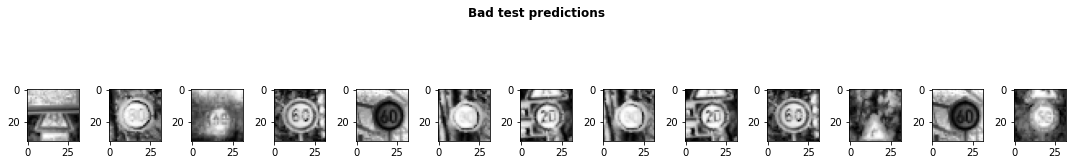

In [123]:
count = 13
idx = np.random.randint(0, high=len(bad_test_pred_imgs), size=13)
show_image_list(bad_test_pred_imgs[idx], bad_test_pred_incorrect_lb[idx], "Bad test predictions", cols=count)

New Images

In [131]:
from PIL import Image
import os

def get_imgs_from_folder(path, size=(32, 32), grayscale=False):
    """  
    Returns a list of images from a folder as a numpy array
    """
    img_list = [os.path.join(path,f) for f in os.listdir(path) if f.endswith(".jpg") or f.endswith(".png")]
    imgs = None 
    if grayscale:
        imgs = np.empty([len(img_list), size[0], size[1]], dtype=np.uint8) 
    else:
        imgs = np.empty([len(img_list), size[0], size[1], 3], dtype=np.uint8) 

    for i, img_path in enumerate(img_list):
        img = Image.open(img_path).convert('RGB')
        img = img.resize(size)
        im = np.array(to_grayscale(img)) if grayscale else np.array(img)
        imgs[i] = im

    return imgs

In [146]:
new_imgs_dir = "./test/"

In [147]:
new_imgs = get_imgs_from_folder(new_imgs_dir)
new_imgs.shape

(7, 32, 32, 3)

In [148]:
new_img_grayscale_clahe = np.asarray(list(map(lambda img: clahe.apply(to_grayscale(img)), new_imgs)))

In [149]:
def class_ids_to_labels(cids):
    return list(map(lambda cid: sign_names[sign_names["ClassId"] == cid] ["SignName"].values[0],  cids))

In [158]:
new_img_lbs = np.array([12,8,6,1,6,4,12])

In [159]:
new_img_lbs_text = class_ids_to_labels(new_img_lbs)
new_img_lbs_text

['Compulsory Turn Right',
 'Compulsory Ahead',
 'Speed Limit 100 Km/hr',
 'Speed Limit 30 Km/hr',
 'Speed Limit 100 Km/hr',
 'Speed Limit 70 Km/hr',
 'Compulsory Turn Right']

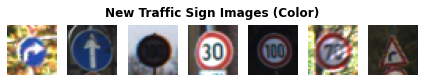

In [160]:
show_image_list(new_imgs, new_img_lbs_text, "New Traffic Sign Images (Color)", cols=len(new_imgs), 
                fig_size=(6,6), show_ticks=False)

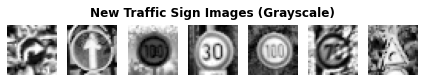

In [161]:
show_image_list(new_img_grayscale_clahe, new_img_lbs_text, "New Traffic Sign Images (Grayscale)", cols=len(new_img_grayscale_clahe), 
                fig_size=(6,6), show_ticks=False)

Predict

In [162]:
new_img_grayscale_clahe_normalised = normalise_images(new_img_grayscale_clahe, X_train_grayscale_equalized) 

In [163]:
new_img_grayscale_clahe_normalised = np.reshape(new_img_grayscale_clahe_normalised, (new_img_grayscale_clahe_normalised.shape[0], 32, 32, 1))

In [164]:
preds = me_g_clahe_norm_take2_drpt_0_50_3x3.predict(new_img_grayscale_clahe_normalised)

INFO:tensorflow:Restoring parameters from ./models/Traffic_Net_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50.chkpt


In [165]:
preds

array([12,  8,  6,  1,  6,  4, 18])

In [245]:
new_img_grayscale_norm_pred_acc = np.sum(new_img_lbs == preds) / len(preds)
print("[Grayscale Normalised] Predictional accuracy on new images: {0}%".format(new_img_grayscale_norm_pred_acc * 100))

[Grayscale Normalised] Predictional accuracy on new images: 85.71428571428571%


In [246]:
new_img_grayscale_clahe_norm_top5_probs = me_g_clahe_norm_take2_drpt_0_50_3x3.predict(new_img_grayscale_clahe_normalised, top_5=True)

INFO:tensorflow:Restoring parameters from ./models/Traffic_Net_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50.chkpt


In [247]:
new_img_grayscale_clahe_norm_softmax_lbs_names = list(map(lambda cids: class_ids_to_labels(cids), new_img_grayscale_clahe_norm_top5_probs.indices))

In [273]:
x=new_img_grayscale_clahe_norm_top5_probs.values
y=new_img_grayscale_clahe_norm_softmax_lbs_names
y=np.array(y)
new_img_grayscale_clahe_norm_softmax_and_labels = list((x,y))

In [274]:
new_img_grayscale_clahe_norm_top5_probs.values[0]

array([1.0000000e+00, 5.2964239e-12, 5.4293907e-13, 5.2935605e-14,
       1.0967157e-14], dtype=float32)

In [275]:
new_img_grayscale_clahe_norm_top5_probs.indices[0]

array([12, 10,  4, 20,  8], dtype=int32)

In [260]:
%matplotlib inline


In [276]:
new_img_grayscale_clahe_norm_softmax_and_labels[0]

array([[1.0000000e+00, 5.2964239e-12, 5.4293907e-13, 5.2935605e-14,
        1.0967157e-14],
       [1.0000000e+00, 1.4883476e-12, 1.1937081e-12, 6.7037216e-14,
        3.5049813e-14],
       [9.9483418e-01, 5.0701811e-03, 9.5597839e-05, 2.6889015e-08,
        7.9112317e-09],
       [1.0000000e+00, 6.8996329e-09, 7.3333351e-10, 1.1372306e-10,
        1.4668976e-12],
       [9.9999869e-01, 1.1684401e-06, 7.8349473e-08, 2.7968919e-13,
        8.1150520e-14],
       [9.9999952e-01, 5.2785191e-07, 2.1837190e-09, 5.1627835e-10,
        6.5073114e-11],
       [9.9999797e-01, 1.4519595e-06, 4.5323739e-07, 8.0102843e-08,
        5.2350483e-08]], dtype=float32)

In [281]:
def show_imgs_softmax_probs(imgs, softmax_probs_lb_names, correct_lbs, fig_size=(15, 7)):
    rows = len(imgs)
    fg, ax = plt.subplots(nrows=rows, ncols=4, figsize=fig_size)
    for i, prob_lb in enumerate(softmax_probs_lb_names):
        correct_lb = correct_lbs[i]
        img = imgs[i]
        ax[i,0].imshow(img)
        ax[i,0].axis("on")

        lb_names = prob_lb[1]
        y_pos = np.arange(len(lb_names))
        vals = prob_lb[0]
        for j in range(0, len(lb_names)):
            c = "b" if lb_names[j] == correct_lb else "r"
            ax[i, 1].barh(j, vals[j], color=c, label="{0}".format(lb_names[j]))

        ax[i, 1].set_yticks(y_pos)
        ax[i, 1].set_yticklabels(lb_names)
        ax[i, 1].invert_yaxis() 
        ax[i, 1].set_xlabel('Class')
        ax[i, 1].set_title('Softmax')  
        ax[i, 1].set_xscale('log')

        ax[i, 1].legend(loc='lower right')
    
    fg.tight_layout()
    plt.show()

SyntaxError: ignored

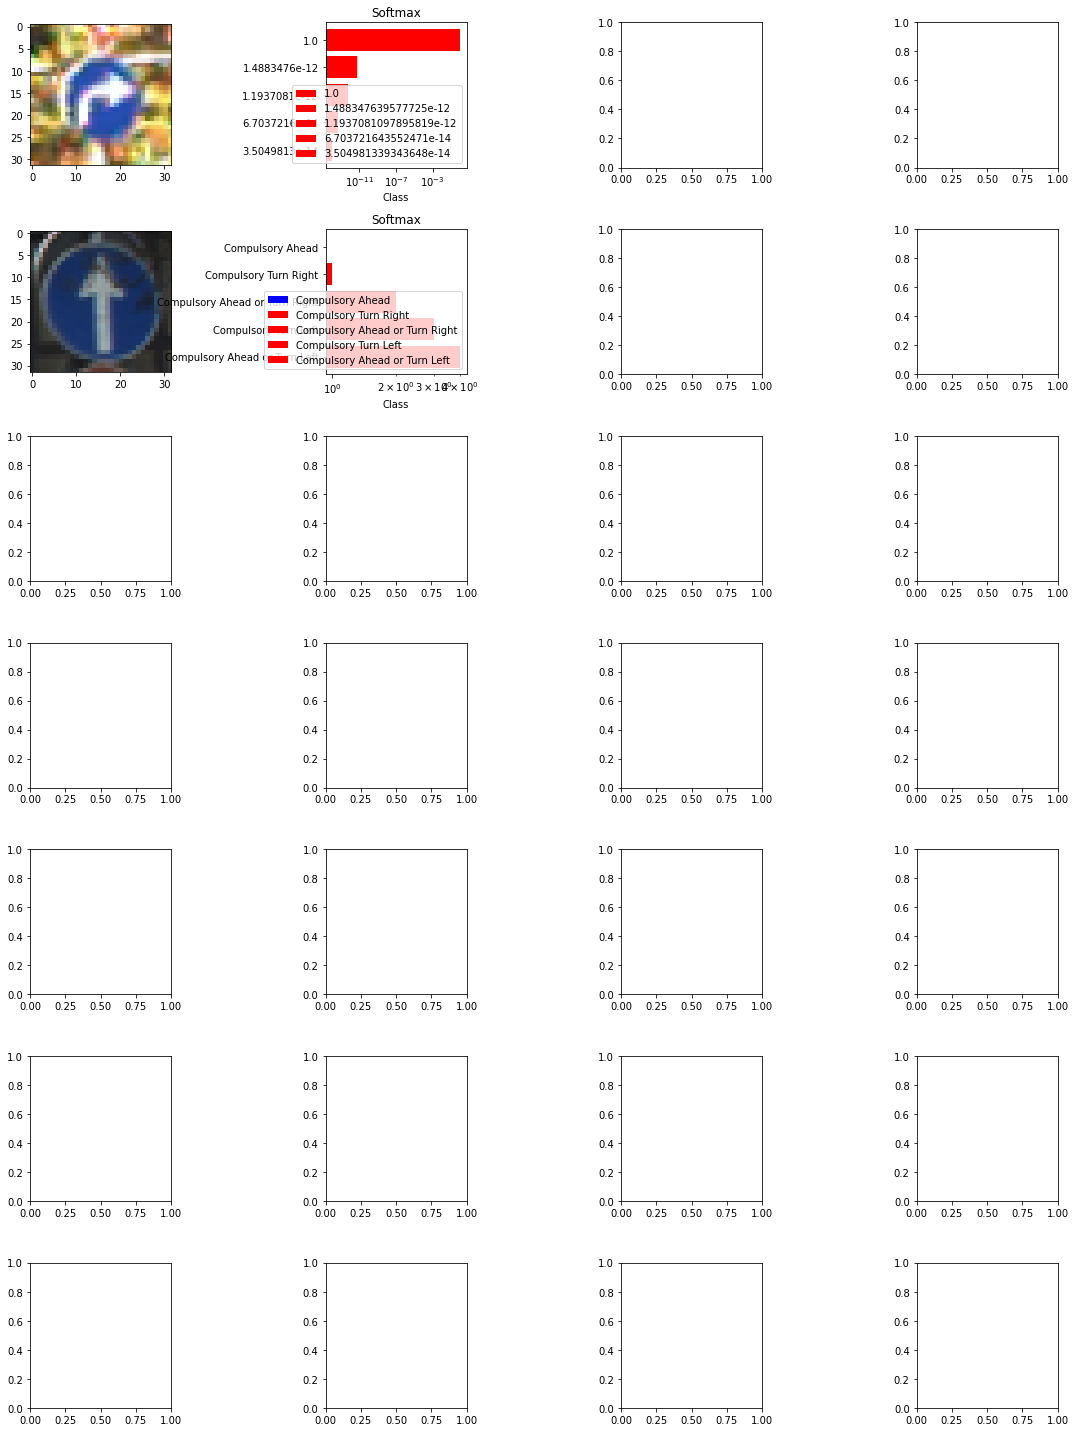

In [280]:
show_imgs_softmax_probs(new_imgs, new_img_grayscale_clahe_norm_softmax_and_labels, new_img_lbs_text, fig_size=(15, 20))
